In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.decomposition import PCA

def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n{model_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    # Calculate metrics for tail regions
    low_mask = y_test <= 0.3
    high_mask = y_test >= 0.7

    if low_mask.any():
        low_rmse = np.sqrt(mean_squared_error(y_test[low_mask], y_pred[low_mask]))
        print(f"Low-end (≤0.3) RMSE: {low_rmse:.4f}")

    if high_mask.any():
        high_rmse = np.sqrt(mean_squared_error(y_test[high_mask], y_pred[high_mask]))
        print(f"High-end (≥0.7) RMSE: {high_rmse:.4f}")

    return y_pred

def plot_predictions(y_true, y_pred, weights=None, title="Model Predictions"):
    plt.figure(figsize=(10, 8))

    if weights is not None:
        scatter = plt.scatter(y_true, y_pred, c=weights, cmap='viridis',
                            alpha=0.6, label='Predictions')
        plt.colorbar(scatter, label='Weight')
    else:
        plt.scatter(y_true, y_pred, alpha=0.6, label='Predictions')

    plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(title)

    # Add metrics to plot
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    plt.text(0.05, 0.95, f'R² = {r2:.3f}\nRMSE = {rmse:.3f}\nMAE = {mae:.3f}',
             transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_feature_importances(model, feature_names, title="Feature Importances"):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print(f"\n{title}:")
    for idx in indices:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")
    pass

"""
def plot_feature_importances(model, feature_names, title="Feature Importances"):
    print("DELETE THIS FUNCTION IF YOU WANT FEATURE IMPORTANCES")
"""

filepath = '../data/E-INSPIRE_I_master_catalogue.csv'



Base Model Evaluation:

Base Model Metrics:
R² Score: 0.7911
RMSE: 0.0742
MAE: 0.0549
Low-end (≤0.3) RMSE: 0.0929
High-end (≥0.7) RMSE: 0.1540


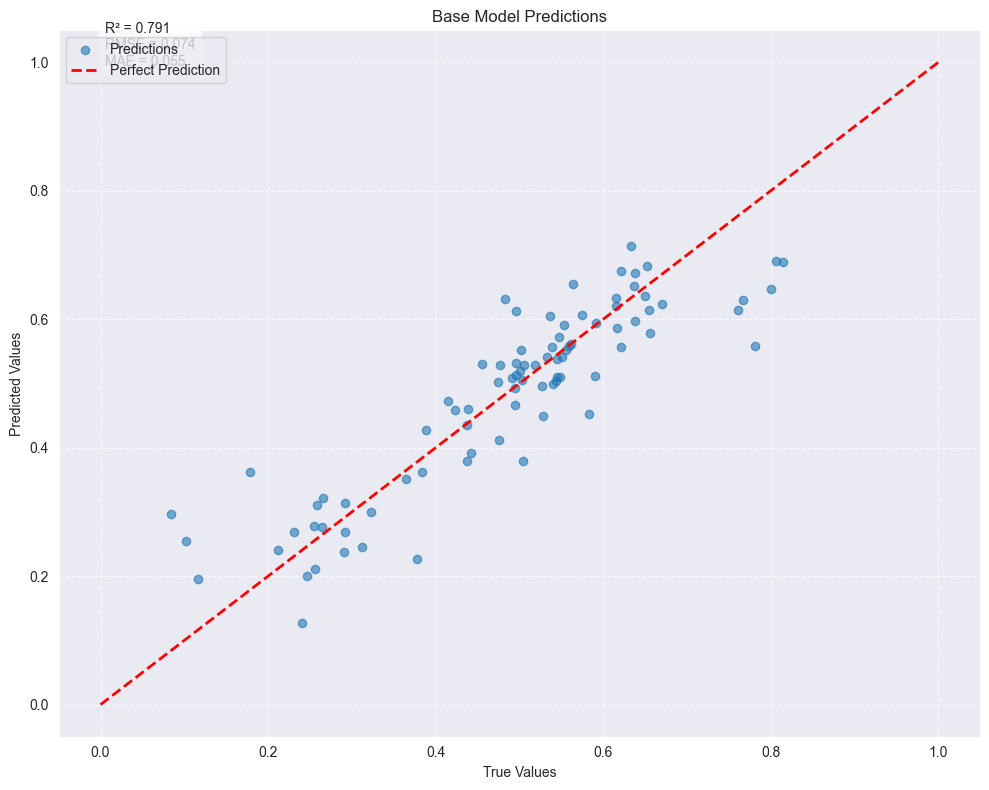

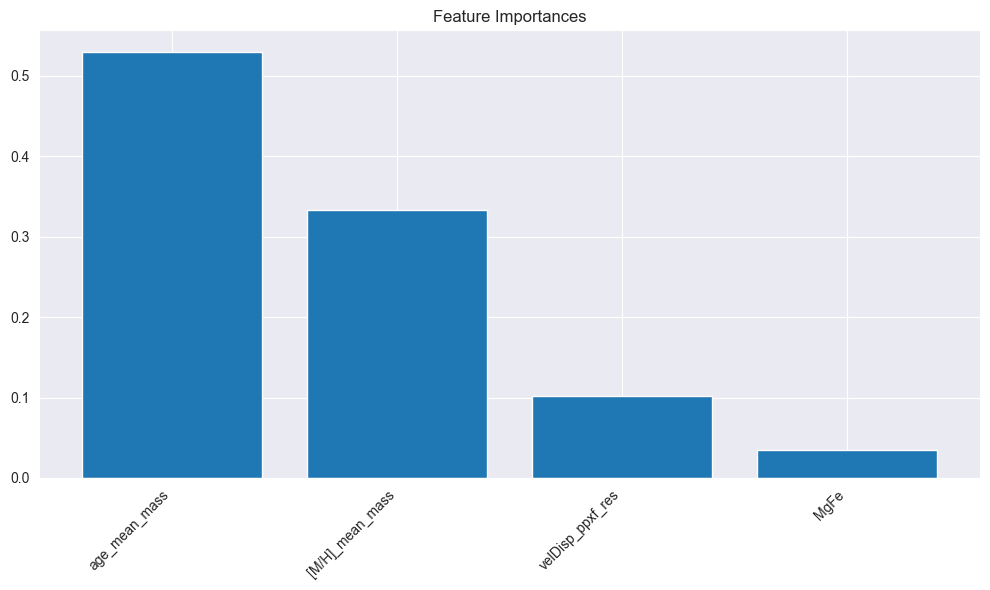


Feature Importances:
age_mean_mass: 0.5302
[M/H]_mean_mass: 0.3333
velDisp_ppxf_res: 0.1017
MgFe: 0.0349


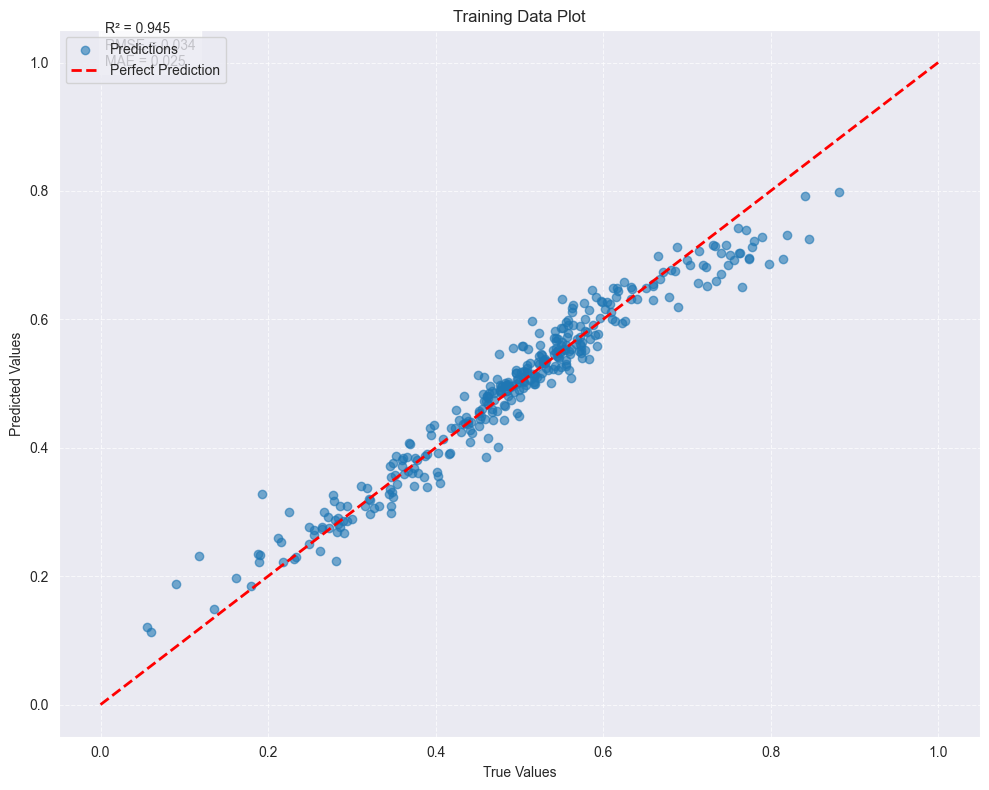

(RandomForestRegressor(max_depth=20, max_features=0.7, min_samples_split=5,
                       n_estimators=500, random_state=42),
 StandardScaler())

In [11]:
def run_base_model(filepath):
    # Load data
    df = pd.read_csv(filepath)
    standard_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']
    X = df[standard_features]
    y = df['DoR']
    
    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    base_model = RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_split=5,
        max_features=0.7,
        random_state=42
    )
    base_model.fit(X_train_scaled, y_train)
    
    # Evaluate and plot
    print("\nBase Model Evaluation:")
    y_pred = evaluate_model(base_model, X_test_scaled, y_test, "Base Model")
    plot_predictions(y_test, y_pred, title="Base Model Predictions")
    plot_feature_importances(base_model, standard_features)
    
    plot_predictions(y_train, base_model.predict(X_train_scaled), title="Training Data Plot")

    return base_model, scaler

run_base_model(filepath)


Model with Error Features Evaluation:

Error Features Model Metrics:
R² Score: 0.8030
RMSE: 0.0721
MAE: 0.0544
Low-end (≤0.3) RMSE: 0.0891
High-end (≥0.7) RMSE: 0.1167


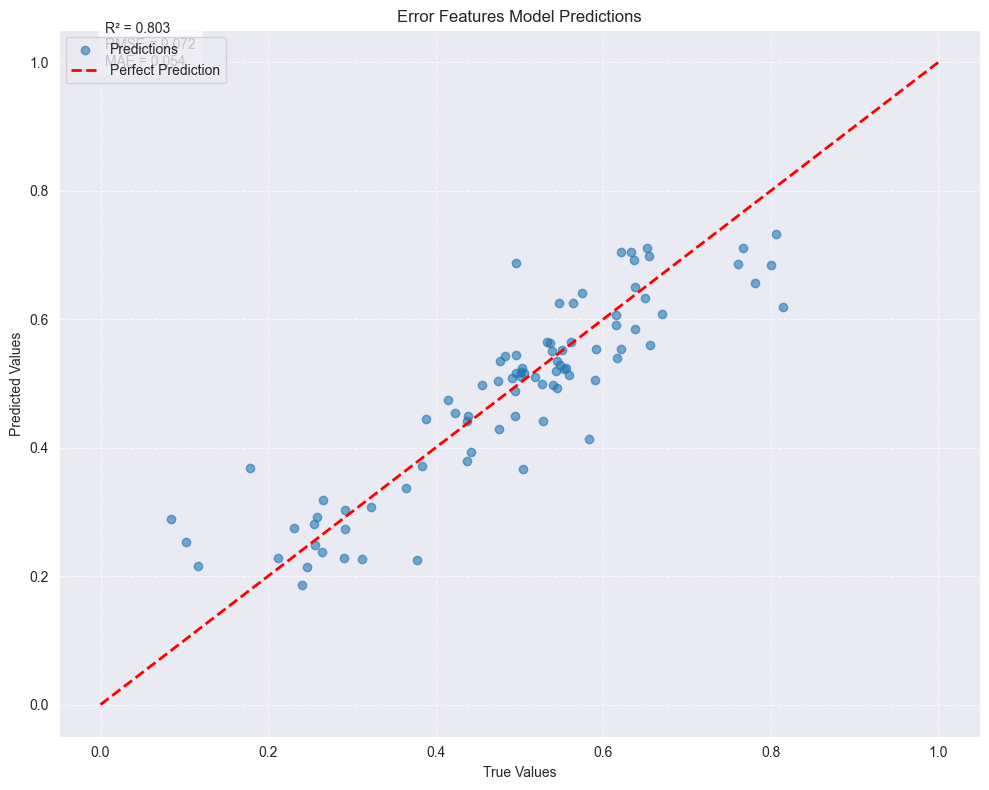

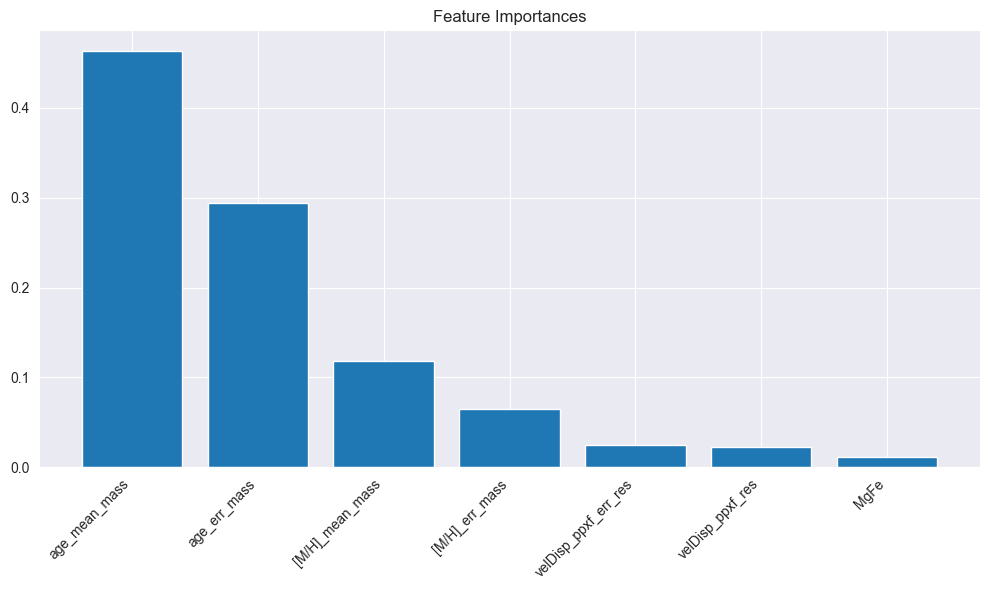


Feature Importances:
age_mean_mass: 0.4629
age_err_mass: 0.2943
[M/H]_mean_mass: 0.1186
[M/H]_err_mass: 0.0652
velDisp_ppxf_err_res: 0.0249
velDisp_ppxf_res: 0.0225
MgFe: 0.0116


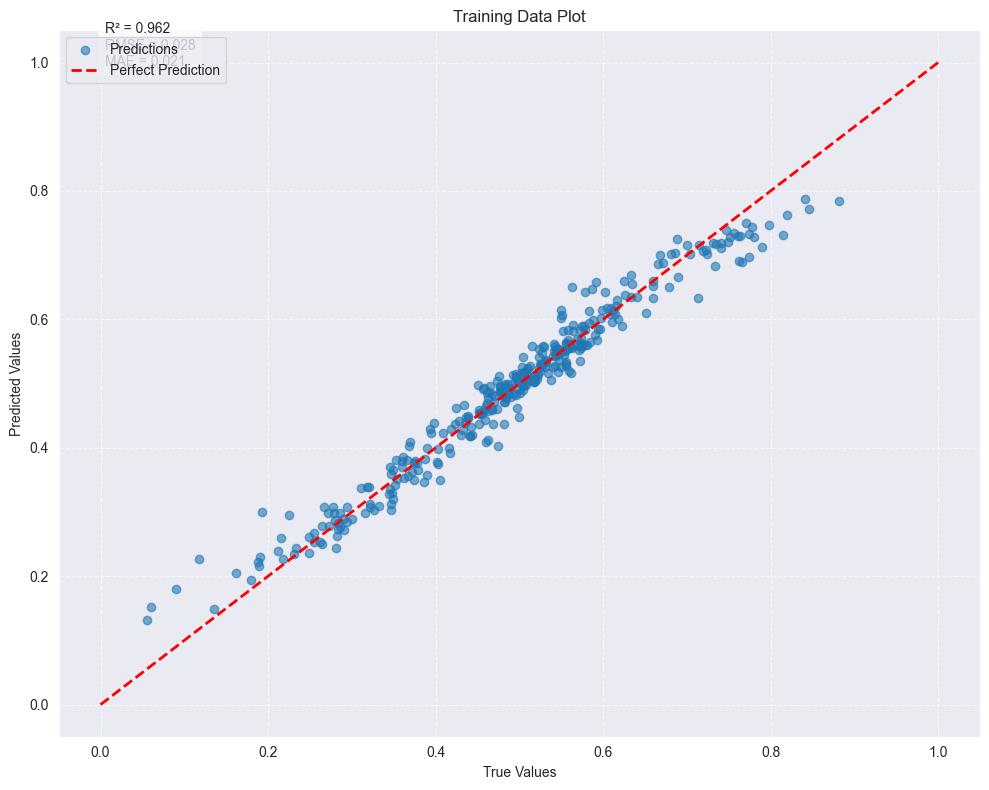

(RandomForestRegressor(max_depth=20, max_features=0.7, min_samples_split=5,
                       n_estimators=500, random_state=42),
 StandardScaler())

In [12]:
def run_error_feature_model(filepath):
    # Load data
    df = pd.read_csv(filepath)
    features_with_errors = [
        'MgFe',
        '[M/H]_mean_mass', '[M/H]_err_mass',
        'velDisp_ppxf_res', 'velDisp_ppxf_err_res',
        'age_mean_mass', 'age_err_mass'
    ]
    X = df[features_with_errors]
    y = df['DoR']
    
    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    error_model = RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_split=5,
        max_features=0.7,
        random_state=42
    )
    error_model.fit(X_train_scaled, y_train)
    
    # Evaluate and plot
    print("\nModel with Error Features Evaluation:")
    y_pred = evaluate_model(error_model, X_test_scaled, y_test, "Error Features Model")
    plot_predictions(y_test, y_pred, title="Error Features Model Predictions")
    plot_feature_importances(error_model, features_with_errors)
    
    plot_predictions(y_train, error_model.predict(X_train_scaled), title="Training Data Plot")
    
    return error_model, scaler

run_error_feature_model(filepath)


Weighted Points Model Evaluation:

Weighted Points Model Metrics:
R² Score: 0.7925
RMSE: 0.0740
MAE: 0.0563
Low-end (≤0.3) RMSE: 0.0907
High-end (≥0.7) RMSE: 0.1393


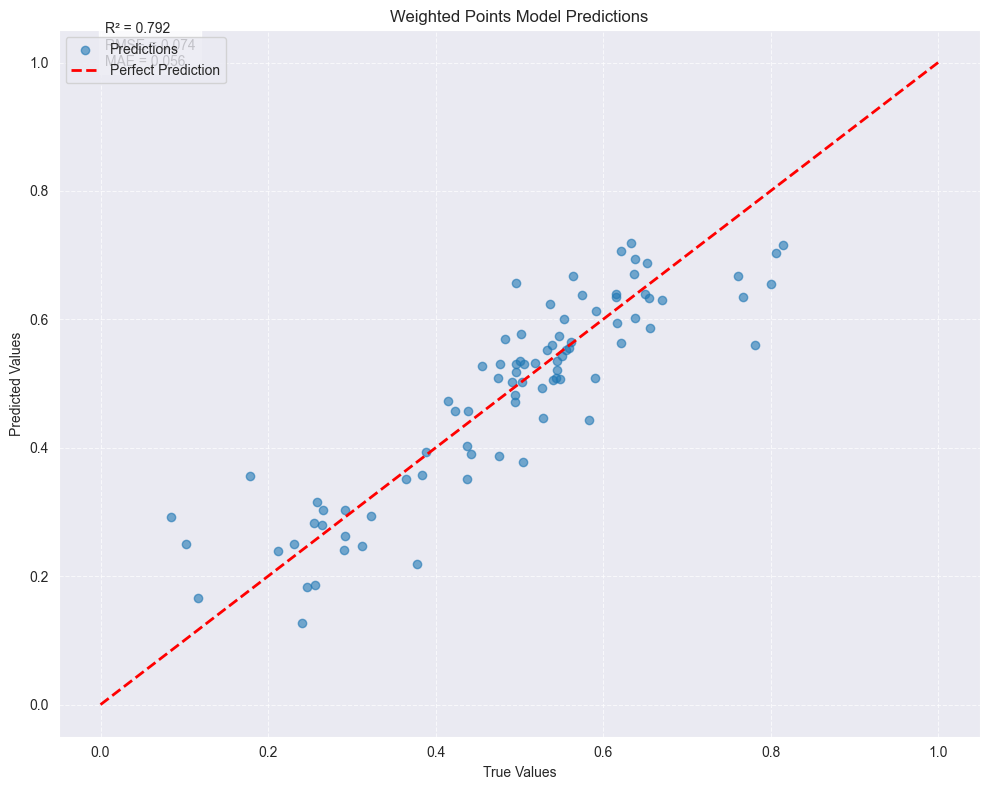

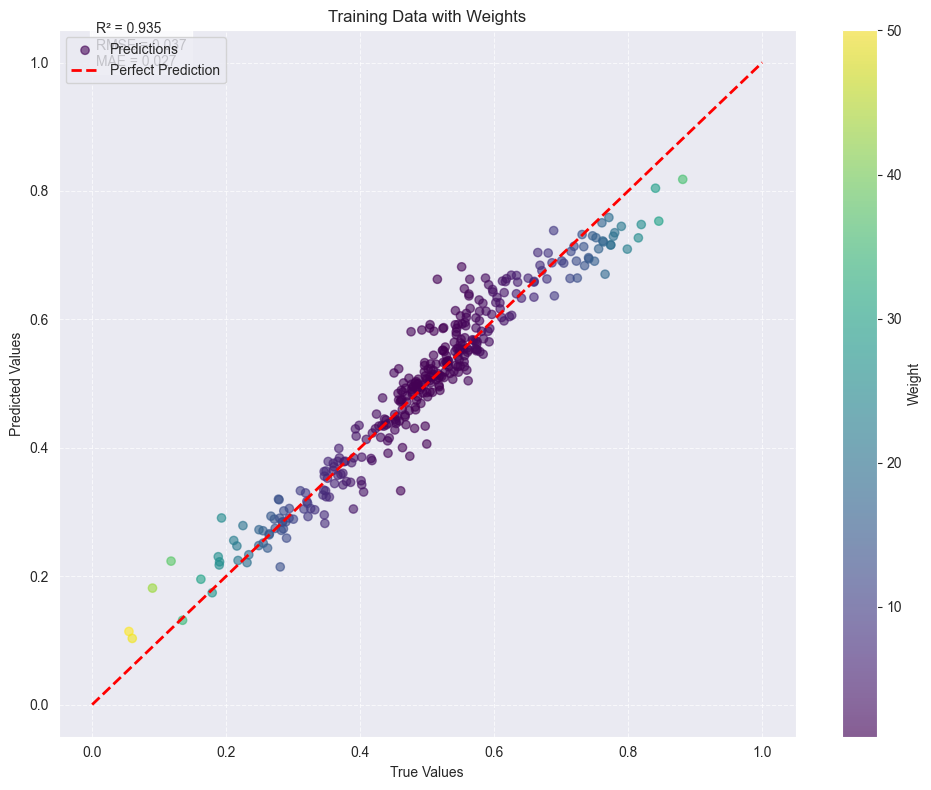

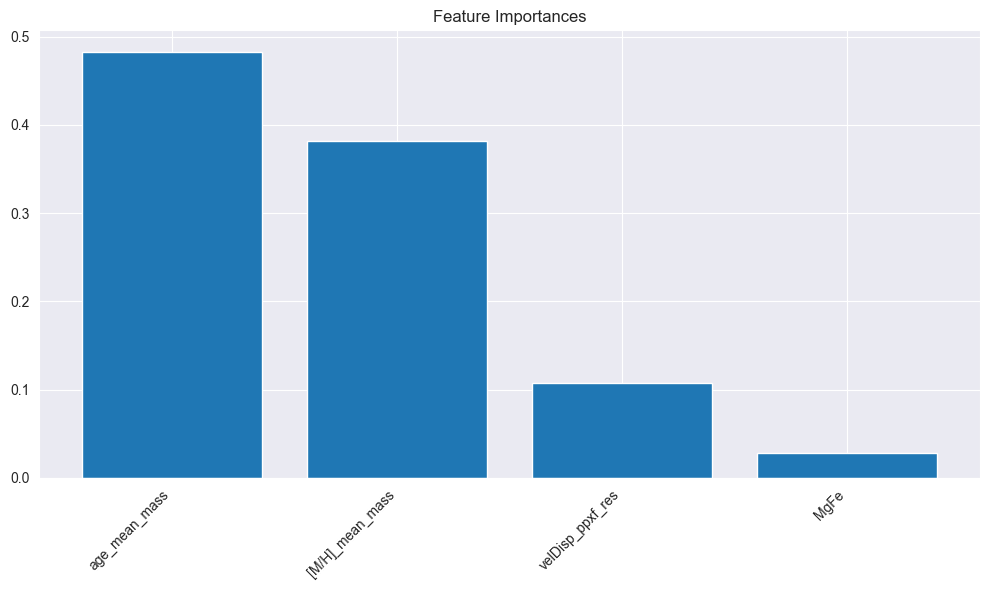


Feature Importances:
age_mean_mass: 0.4830
[M/H]_mean_mass: 0.3819
velDisp_ppxf_res: 0.1075
MgFe: 0.0277


(RandomForestRegressor(max_depth=20, max_features=0.7, min_samples_split=5,
                       n_estimators=500, random_state=42),
 StandardScaler(),
 66      1.533538
 132     1.004180
 407    14.106724
 31      1.004971
 84     13.766681
          ...    
 71      1.588991
 106    15.616532
 270     2.796740
 348     1.012584
 102     3.970252
 Name: DoR, Length: 344, dtype: float64)

In [22]:
def run_weighted_points_model(filepath, max_weight = 10, power =2):
    # Load data
    df = pd.read_csv(filepath)
    standard_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']
    X = df[standard_features]
    y = df['DoR']
    
    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Calculate weights
    mean_y = np.median(y_train)
    distances = np.abs(y_train - mean_y)
    weights = 1 + (distances / np.max(distances))**power * (max_weight - 1)
    
    # Train weighted model
    weighted_model = RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_split=5,
        max_features=0.7,
        random_state=42
    )
    weighted_model.fit(X_train_scaled, y_train, sample_weight=weights)
    
    # Evaluate and plot
    print("\nWeighted Points Model Evaluation:")
    y_pred = evaluate_model(weighted_model, X_test_scaled, y_test, "Weighted Points Model")
    plot_predictions(y_test, y_pred, title="Weighted Points Model Predictions")
    plot_predictions(y_train, weighted_model.predict(X_train_scaled), 
                    weights=weights, title="Training Data with Weights")
    
    plot_feature_importances(weighted_model, standard_features)
    
    return weighted_model, scaler, weights

run_weighted_points_model(filepath, max_weight = 50, power =2)


Polynomial Features Model Evaluation:

Polynomial Features Model Metrics:
R² Score: 0.7962
RMSE: 0.0733
MAE: 0.0557
Low-end (≤0.3) RMSE: 0.0917
High-end (≥0.7) RMSE: 0.1408


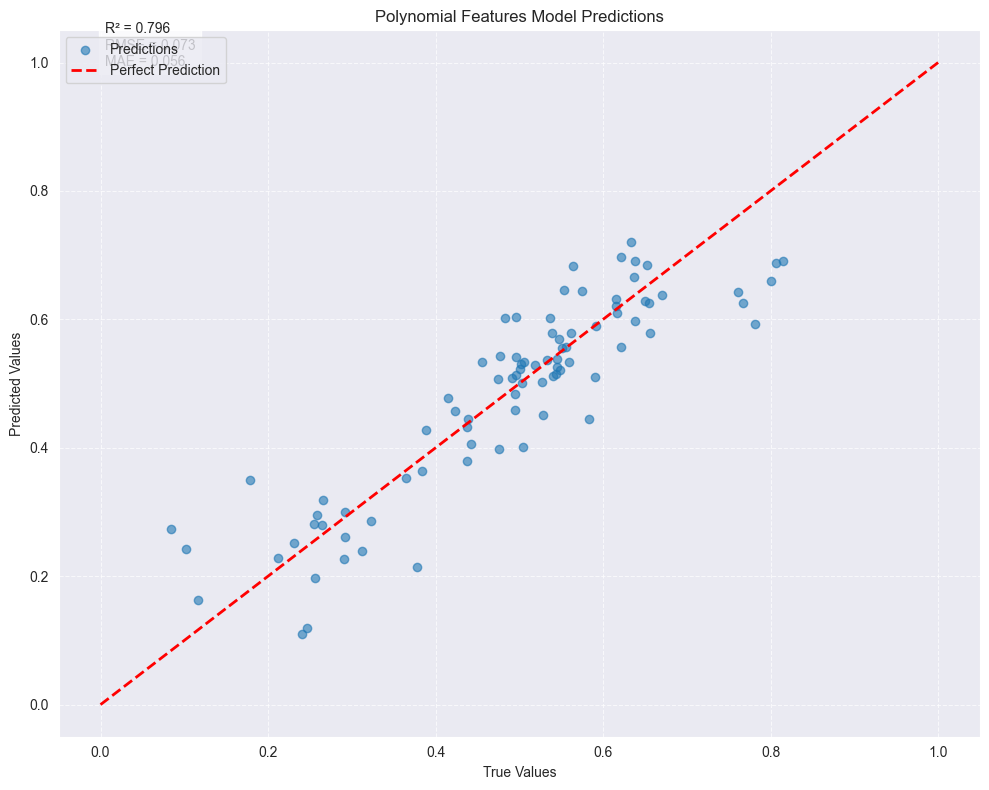

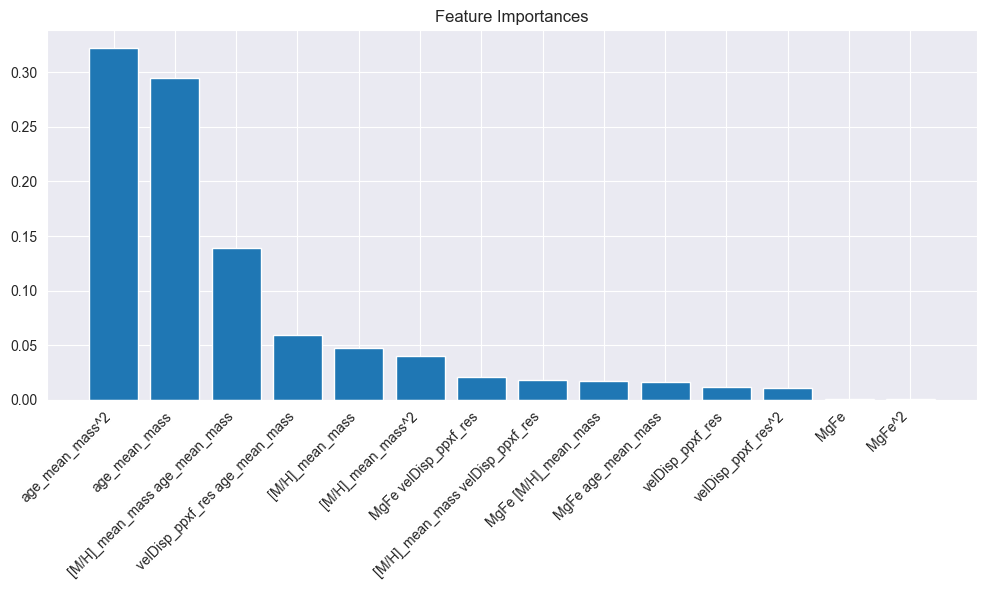


Feature Importances:
age_mean_mass^2: 0.3223
age_mean_mass: 0.2948
[M/H]_mean_mass age_mean_mass: 0.1391
velDisp_ppxf_res age_mean_mass: 0.0590
[M/H]_mean_mass: 0.0470
[M/H]_mean_mass^2: 0.0397
MgFe velDisp_ppxf_res: 0.0208
[M/H]_mean_mass velDisp_ppxf_res: 0.0185
MgFe [M/H]_mean_mass: 0.0169
MgFe age_mean_mass: 0.0166
velDisp_ppxf_res: 0.0121
velDisp_ppxf_res^2: 0.0112
MgFe: 0.0010
MgFe^2: 0.0010


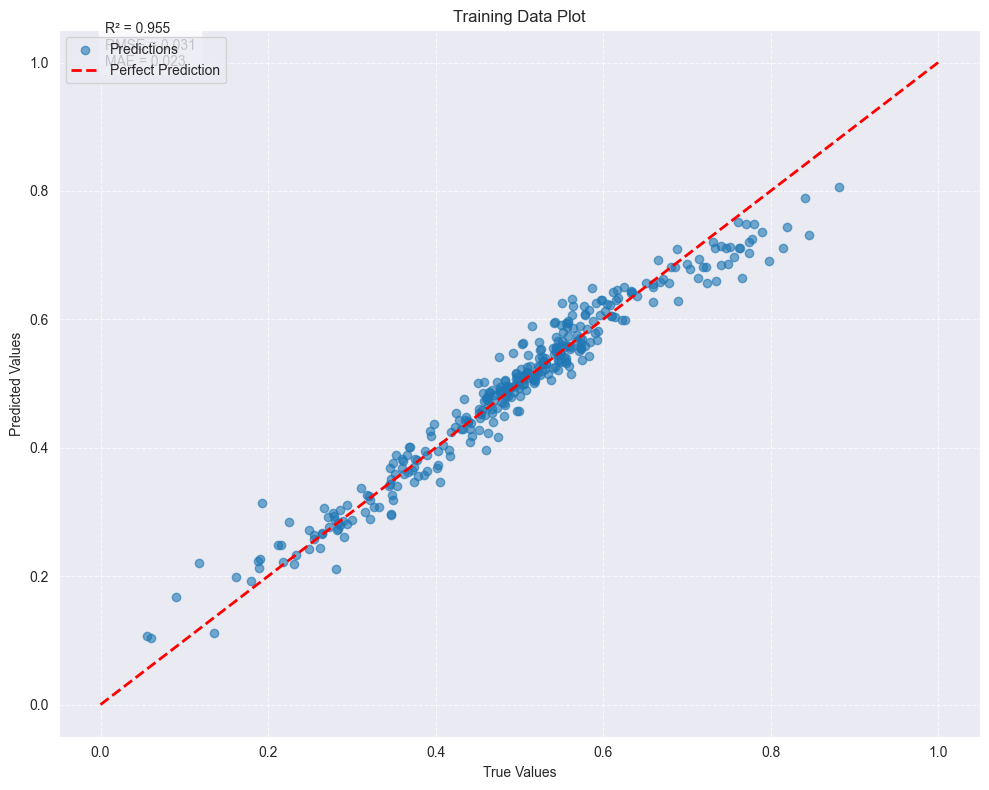

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=20, max_features=0.7,
                                       min_samples_split=5, n_estimators=500,
                                       random_state=42))])

In [14]:
def run_polynomial_model(filepath):
    # Load data
    df = pd.read_csv(filepath)
    standard_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']
    X = df[standard_features]
    y = df['DoR']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create and train polynomial model
    poly_model = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(
            n_estimators=500,
            max_depth=20,
            min_samples_split=5,
            max_features=0.7,
            random_state=42
        ))
    ])
    
    poly_model.fit(X_train, y_train)
    
    # Evaluate and plot
    print("\nPolynomial Features Model Evaluation:")
    y_pred = evaluate_model(poly_model, X_test, y_test, "Polynomial Features Model")
    plot_predictions(y_test, y_pred, title="Polynomial Features Model Predictions")
    
    # Get feature names for polynomial features
    poly_features = poly_model.named_steps['poly'].get_feature_names_out(standard_features)
    plot_feature_importances(poly_model.named_steps['rf'], poly_features)
    
    plot_predictions(y_train, poly_model.predict(X_train), title="Training Data Plot")

    return poly_model

run_polynomial_model(filepath)


Ensemble Model Evaluation:

Ensemble Model Metrics:
R² Score: 0.7841
RMSE: 0.0755
MAE: 0.0555
Low-end (≤0.3) RMSE: 0.1006
High-end (≥0.7) RMSE: 0.1526


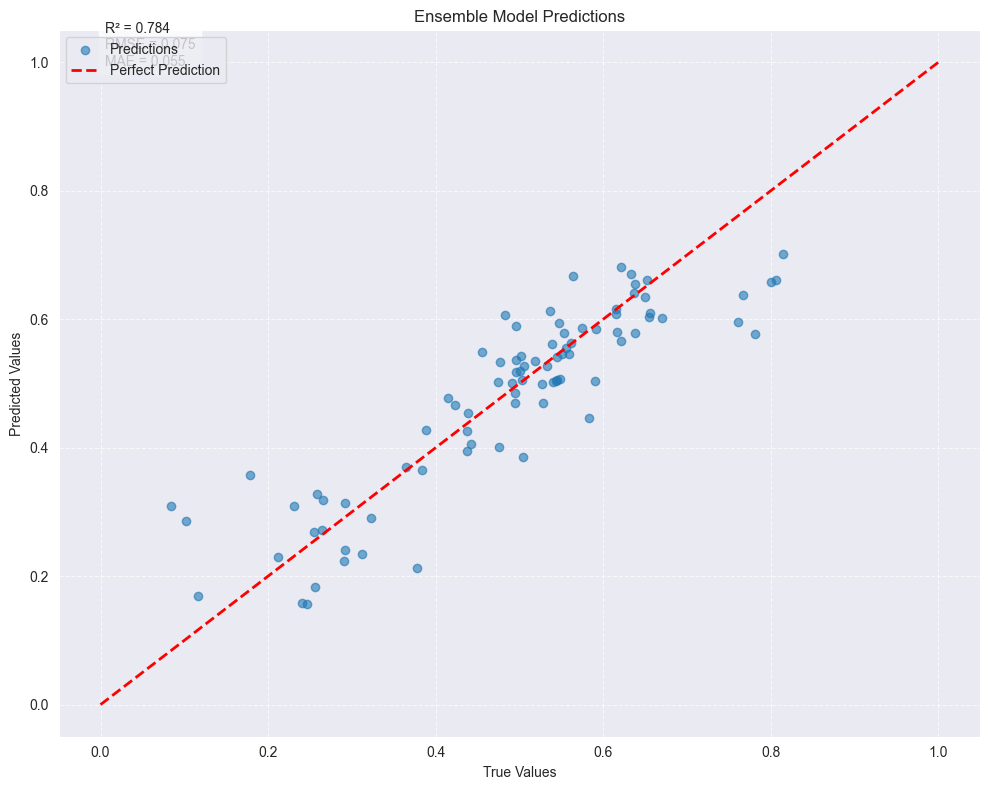

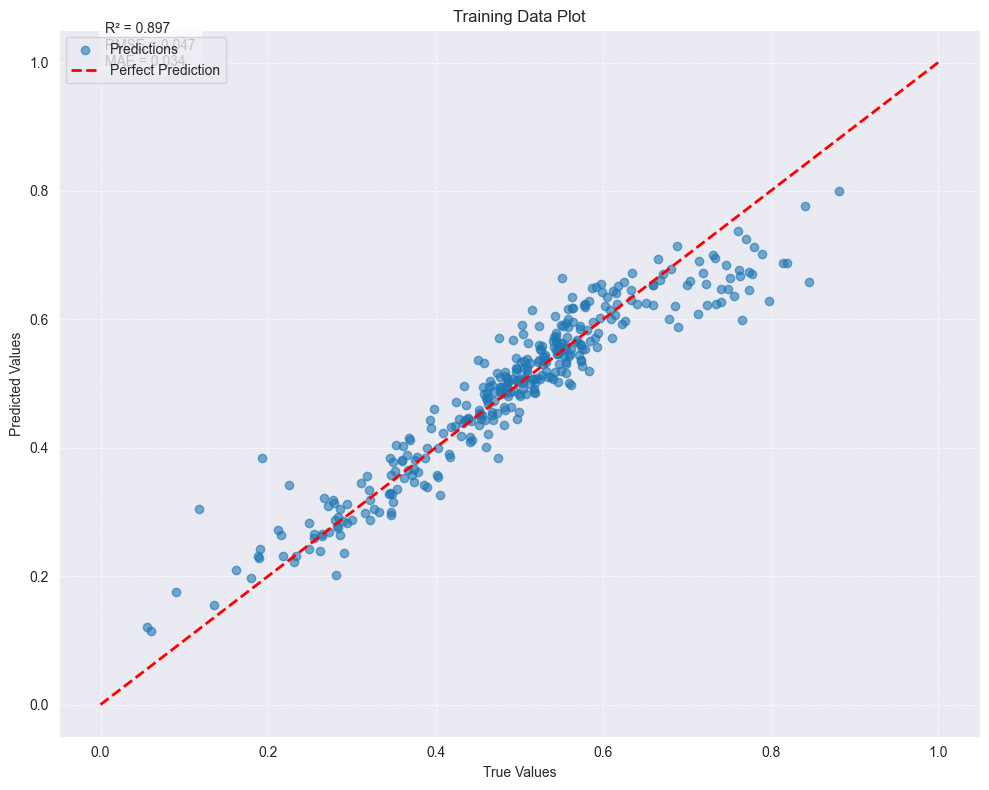

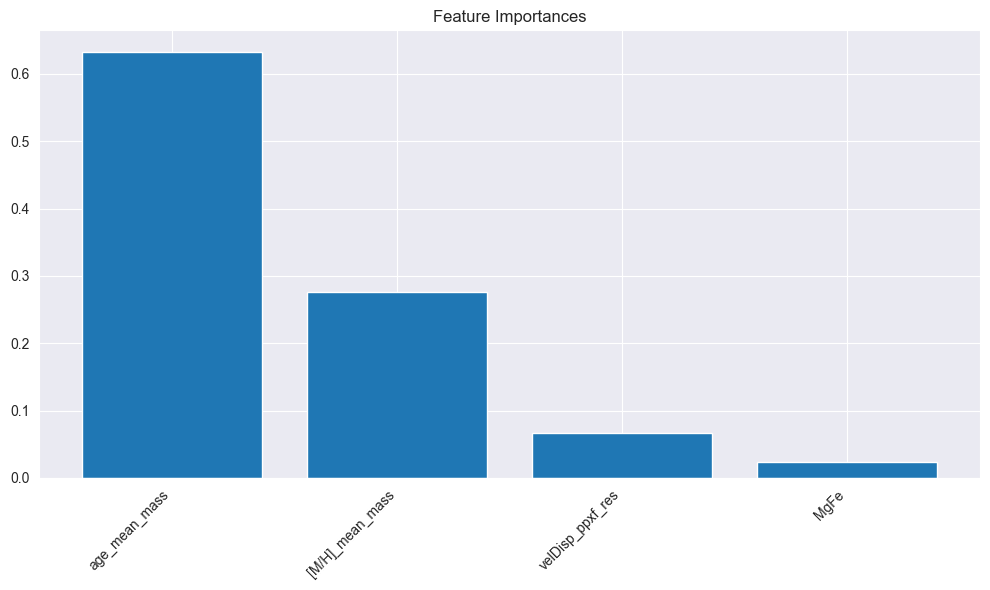


Feature Importances:
age_mean_mass: 0.6328
[M/H]_mean_mass: 0.2761
velDisp_ppxf_res: 0.0672
MgFe: 0.0239


(VotingRegressor(estimators=[('rf',
                              RandomForestRegressor(max_depth=22,
                                                    max_features=0.793,
                                                    max_samples=0.5,
                                                    min_samples_split=4,
                                                    n_estimators=460,
                                                    random_state=42)),
                             ('svr', SVR(C=1, epsilon=0.01, gamma='auto'))],
                 weights=[0.7, 0.3]),
 StandardScaler(),
 RandomForestRegressor(max_depth=22, max_features=0.793, max_samples=0.5,
                       min_samples_split=4, n_estimators=460, random_state=42),
 SVR(C=1, epsilon=0.01, gamma='auto'))

In [15]:
def run_ensemble_model(filepath):
    # Load data
    df = pd.read_csv(filepath)
    standard_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']
    X = df[standard_features]
    y = df['DoR']

    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create both models with optimized parameters
    rf = RandomForestRegressor(
        n_estimators=460,
        max_depth=22,
        max_features=0.793,
        max_samples=0.5,
        min_samples_leaf=1,
        min_samples_split=4,
        random_state=42
    )

    svr = SVR(
        kernel='rbf',
        C=1,
        epsilon=0.01,
        gamma='auto'
    )

    ensemble = VotingRegressor([
        ('rf', rf),
        ('svr', svr)
    ], weights=[0.7, 0.3])

    ensemble.fit(X_train_scaled, y_train)

    # Evaluate and plot
    print("\nEnsemble Model Evaluation:")
    y_pred = evaluate_model(ensemble, X_test_scaled, y_test, "Ensemble Model")
    plot_predictions(y_test, y_pred, title="Ensemble Model Predictions")

    # Plot training data predictions
    plot_predictions(y_train, ensemble.predict(X_train_scaled),
                     title="Training Data Plot")


    plot_feature_importances(ensemble.named_estimators_['rf'], standard_features)

    return ensemble, scaler, rf, svr


run_ensemble_model(filepath)


Training Improved Neural Network Ensemble...

Improved Neural Network Ensemble Evaluation:

Neural Network Ensemble Metrics:
R² Score: 0.7971
RMSE: 0.0732
MAE: 0.0545
Low-end (≤0.3) RMSE: 0.0917
High-end (≥0.7) RMSE: 0.1461


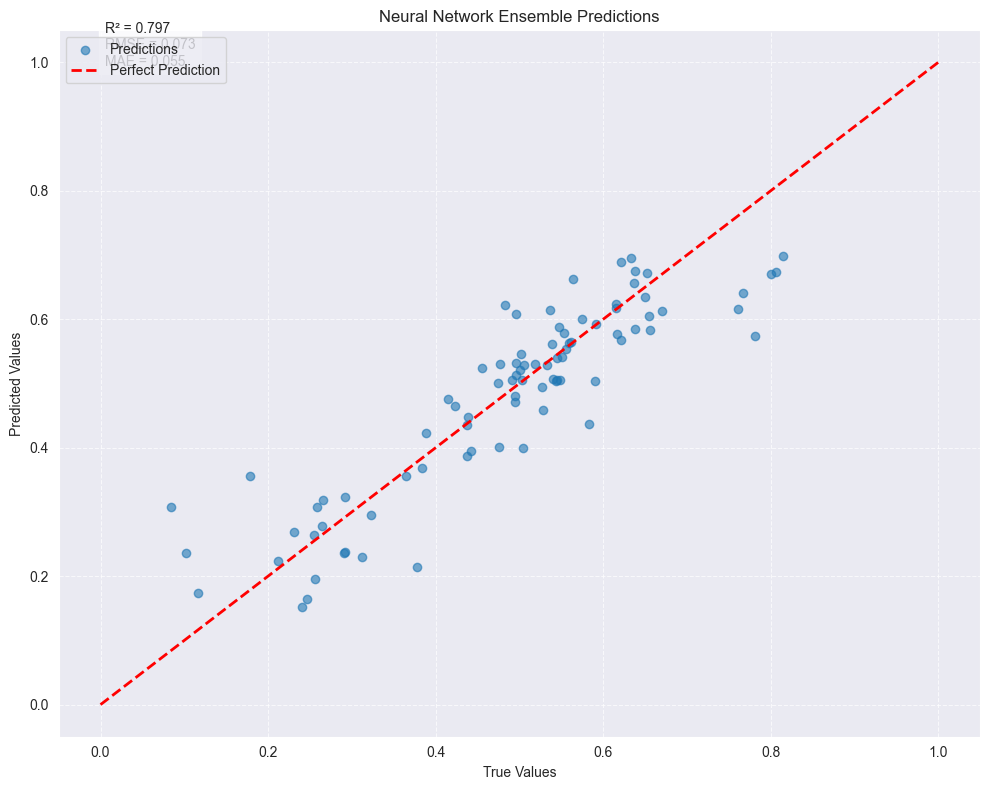

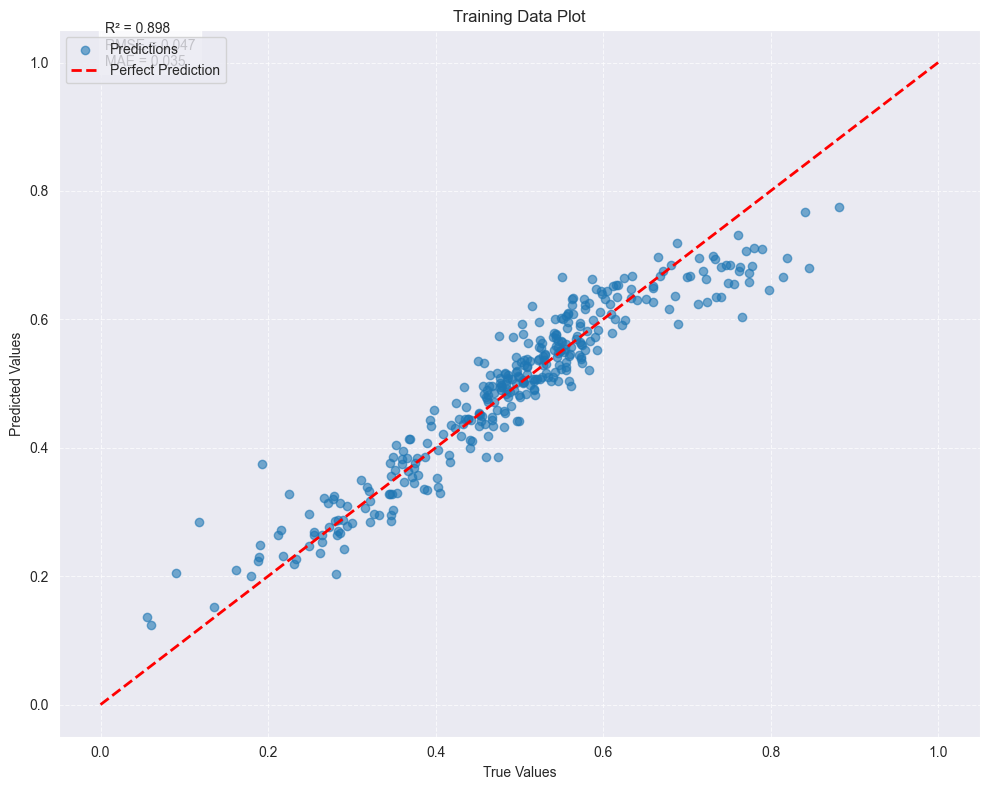

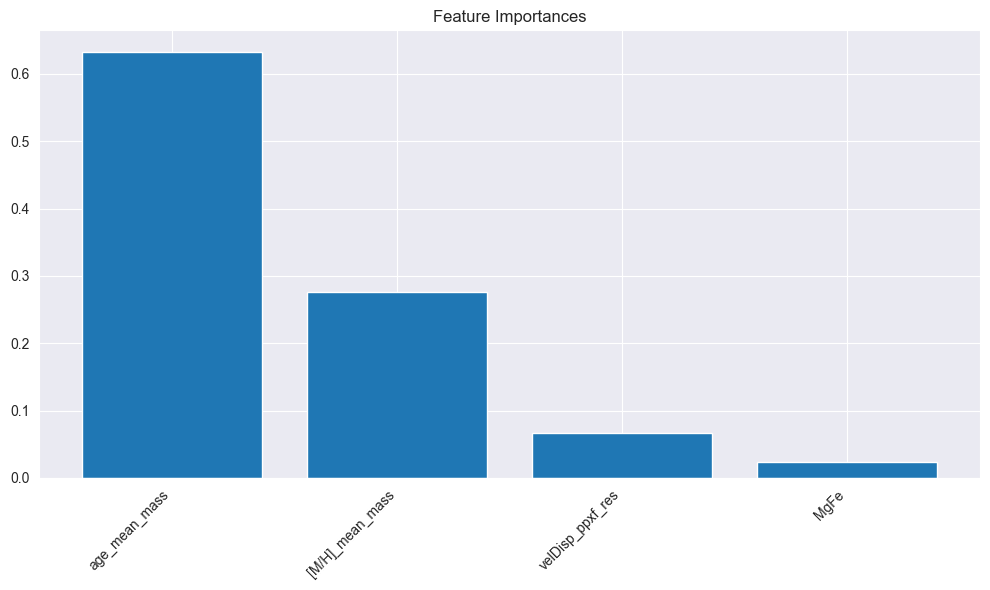


Feature Importances:
age_mean_mass: 0.6328
[M/H]_mean_mass: 0.2761
velDisp_ppxf_res: 0.0672
MgFe: 0.0239

Individual Model Performances:

Random Forest alone:

Random Forest Metrics:
R² Score: 0.8020
RMSE: 0.0723
MAE: 0.0541
Low-end (≤0.3) RMSE: 0.0854
High-end (≥0.7) RMSE: 0.1506

Neural Network alone:

Neural Network Metrics:
R² Score: 0.7291
RMSE: 0.0845
MAE: 0.0612
Low-end (≤0.3) RMSE: 0.1296
High-end (≥0.7) RMSE: 0.1328


(VotingRegressor(estimators=[('rf',
                              RandomForestRegressor(max_depth=22,
                                                    max_features=0.793,
                                                    max_samples=0.5,
                                                    min_samples_split=4,
                                                    n_estimators=460,
                                                    random_state=42)),
                             ('nn',
                              MLPRegressor(activation='tanh', alpha=0.01,
                                           hidden_layer_sizes=(64, 32),
                                           max_iter=2000, random_state=42,
                                           solver='lbfgs'))],
                 weights=[0.8, 0.2]),
 StandardScaler(),
 RandomForestRegressor(max_depth=22, max_features=0.793, max_samples=0.5,
                       min_samples_split=4, n_estimators=460, random_state=42),
 MLPRegressor

In [16]:
from sklearn.neural_network import MLPRegressor

def run_nn_ensemble_model(filepath):
    # Load data
    df = pd.read_csv(filepath)
    standard_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']
    X = df[standard_features]
    y = df['DoR']
    
    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create models
    rf = RandomForestRegressor(
        n_estimators=460,
        max_depth=22,
        max_features=0.793,
        max_samples=0.5,
        min_samples_leaf=1,
        min_samples_split=4,
        random_state=42
    )
    
    nn = MLPRegressor(
        hidden_layer_sizes=(64, 32),  
        activation='tanh',            
        solver='lbfgs',              
        alpha=0.01,                  
        max_iter=2000,
        random_state=42
    )
    
    ensemble = VotingRegressor([
        ('rf', rf),
        ('nn', nn)
    ], weights=[0.8, 0.2])  # Much higher weight to RF given performance difference
    
    # Train models
    print("\nTraining Improved Neural Network Ensemble...")
    ensemble.fit(X_train_scaled, y_train)
    
    # Evaluate and plot
    print("\nImproved Neural Network Ensemble Evaluation:")
    y_pred = evaluate_model(ensemble, X_test_scaled, y_test, "Neural Network Ensemble")
    plot_predictions(y_test, y_pred, title="Neural Network Ensemble Predictions")
    
    # Plot training data predictions
    plot_predictions(y_train, ensemble.predict(X_train_scaled), 
                    title="Training Data Plot")
    
    # Plot feature importances for RF component
    plot_feature_importances(ensemble.named_estimators_['rf'], standard_features)
    
 
    # Additional evaluation - individual model performances
    print("\nIndividual Model Performances:")
    print("\nRandom Forest alone:")
    rf.fit(X_train_scaled, y_train)
    rf_pred = rf.predict(X_test_scaled)
    evaluate_model(rf, X_test_scaled, y_test, "Random Forest")
    
    print("\nNeural Network alone:")
    nn.fit(X_train_scaled, y_train)

    nn_pred = nn.predict(X_test_scaled)
    evaluate_model(nn, X_test_scaled, y_test, "Neural Network")
    
    return ensemble, scaler, rf, nn

run_nn_ensemble_model(filepath)